In [1]:
# Ignore this cell.. Just some standard stuff I do

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.mixed_precision import experimental as mixed_precision
import os

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(1024*6))])
#tf.debugging.set_log_device_placement(True)
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)

2.2.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Sample code for generating sequences for pose

import random
import numpy as np


ARCHS = ["lstm"]#["lstm", "gru"]
DATAPOINTS = 32*2000 #Controls the number of rows of datasets to be generated (For some reason, this needs to be a multiple of 32)
MAX_NUM_FRAMES_PER_POSE = 50 #50 #This is the number of frames that can detect one pose. Like a pose hold of 1 sec can result in 10 frames of one pose
NUM_POSES = 7
REP = [0, 1, 2, 3, 4, 5, 6, 2, 1, 0]
MAX_SEQ_SIZE = 32*20 #Number of columns 
inputs = np.empty([DATAPOINTS, MAX_SEQ_SIZE, NUM_POSES], np.int32) # Format: 3D array: Row index, Column, (0 index for input, 1 index for total number of poses in sequence)
targets = np.empty([DATAPOINTS, MAX_SEQ_SIZE, len(REP)], np.float32) # Format: 2D array: Row index, Column


In [3]:
# load numpy array from npz file
from numpy import load
inputs = load('inputs.npz')['arr_0']
targets = load('targets.npz')['arr_0']

In [4]:
import collections
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed, GRU, SimpleRNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import argparse

batches = 32
def get_model(seq_size, arch, batch):
    if arch == "lstm":
        hidden_size = 20
        model = Sequential()
        model.add(LSTM(hidden_size, batch_input_shape=(batch, seq_size, NUM_POSES), return_sequences=True, stateful=True))
        #model.add(Dropout(0.5))
        model.add(TimeDistributed(Dense(len(REP))))
        model.add(Activation('softmax'))
    elif arch == "gru":
        hidden_size = 20
        model = Sequential()
        model.add(GRU(hidden_size, input_shape=(seq_size, NUM_POSES), return_sequences=True))
        #model.add(Dropout(0.5))
        model.add(TimeDistributed(Dense(len(REP))))
        model.add(Activation('softmax'))
    elif arch == "simpleRNN":
        hidden_size = 20
        model = Sequential()
        model.add(SimpleRNN(128, input_shape=(seq_size, NUM_POSES)))
        #model.add(Dropout(0.5))
        model.add(Dense(len(REP)))
        model.add(Activation('softmax'))
    elif arch == "BigOne":
        hidden_size = 500 #20
        model = Sequential()
        #model.add(Embedding(vocabulary, input_length=num_steps))
        model.add(LSTM(hidden_size, batch_input_shape=(batch, seq_size, NUM_POSES), return_sequences=True, stateful=True))
        model.add(LSTM(hidden_size, return_sequences=True, stateful=True))
        model.add(LSTM(hidden_size, return_sequences=True, stateful=True))
        model.add(LSTM(hidden_size, return_sequences=True, stateful=True))
        #model.add(Dropout(0.5))
        model.add(TimeDistributed(Dense(100)))
        model.add(TimeDistributed(Dense(100)))
        model.add(TimeDistributed(Dense(100)))
        # model.add(Dense(40))
        # model.add(Dense(40))
        #model.add(Dense(1, activation='softmax'))
        #model.add(TimeDistributed(Dense(total_poses)))
        model.add(TimeDistributed(Dense(len(REP))))
        model.add(Activation('softmax'))
    return model

training_models = {}
prediction_models = {}
for arch in ARCHS:
    training_models[arch] = get_model(MAX_SEQ_SIZE, arch, batches)

In [5]:
# model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer='adam', metrics=['categorical_accuracy'])
for arch in ARCHS:
    optimizer = keras.optimizers.Adam(lr=0.001)
    training_models[arch].compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    training_models[arch].fit(inputs, targets, batch_size=batches, epochs=10, verbose=1)
    training_models[arch].reset_states()

Epoch 1/10
2000/2000 [==============================] - 40s 20ms/step - loss: 0.5387 - categorical_accuracy: 0.8333
Epoch 2/10
2000/2000 [==============================] - 40s 20ms/step - loss: 0.2765 - categorical_accuracy: 0.9060
Epoch 3/10
2000/2000 [==============================] - 40s 20ms/step - loss: 0.2128 - categorical_accuracy: 0.9272
Epoch 4/10
2000/2000 [==============================] - 40s 20ms/step - loss: 0.2735 - categorical_accuracy: 0.9096
Epoch 5/10
2000/2000 [==============================] - 40s 20ms/step - loss: 0.2464 - categorical_accuracy: 0.9104
Epoch 6/10
2000/2000 [==============================] - 40s 20ms/step - loss: 0.2114 - categorical_accuracy: 0.9233
Epoch 7/10
2000/2000 [==============================] - 40s 20ms/step - loss: 0.1791 - categorical_accuracy: 0.9379
Epoch 8/10
2000/2000 [==============================] - 40s 20ms/step - loss: 0.1730 - categorical_accuracy: 0.9399
Epoch 9/10
2000/2000 [==============================] - 40s 20ms/step - 

In [6]:
for arch in ARCHS:
    optimizer = keras.optimizers.Adam(lr=0.0000001)
    training_models[arch].compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    training_models[arch].fit(inputs, targets, batch_size=batches, epochs=10, verbose=1)
    training_models[arch].reset_states()

Epoch 1/10
2000/2000 [==============================] - 40s 20ms/step - loss: 0.1435 - categorical_accuracy: 0.9478
Epoch 2/10
2000/2000 [==============================] - 40s 20ms/step - loss: 0.1435 - categorical_accuracy: 0.9478
Epoch 3/10
2000/2000 [==============================] - 40s 20ms/step - loss: 0.1435 - categorical_accuracy: 0.9478
Epoch 4/10
2000/2000 [==============================] - 40s 20ms/step - loss: 0.1435 - categorical_accuracy: 0.9478
Epoch 5/10
2000/2000 [==============================] - 40s 20ms/step - loss: 0.1435 - categorical_accuracy: 0.9478
Epoch 6/10
2000/2000 [==============================] - 40s 20ms/step - loss: 0.1433 - categorical_accuracy: 0.9479
Epoch 7/10
2000/2000 [==============================] - 40s 20ms/step - loss: 0.1433 - categorical_accuracy: 0.9479
Epoch 8/10
2000/2000 [==============================] - 40s 20ms/step - loss: 0.1433 - categorical_accuracy: 0.9479
Epoch 9/10
2000/2000 [==============================] - 40s 20ms/step - 

In [7]:
for arch in ARCHS:
    test_loss, test_acc = training_models[arch].evaluate(inputs, targets, batch_size=batches, verbose=2)
    print(arch+' Test accuracy:', test_acc)

2000/2000 - 20s - loss: 0.1432 - categorical_accuracy: 0.9479
lstm Test accuracy: 0.9479385614395142


In [8]:
# probability_model = tf.keras.Sequential([model, 
#                                          tf.keras.layers.Softmax()])
# print(inputs[0][0].shape)
# predictions = model.predict(inputs, verbose=0)

In [9]:
for arch in ARCHS:
    print(arch)
    training_models[arch].save_weights(arch+'_model.h5')

import time
time.sleep(2)

lstm


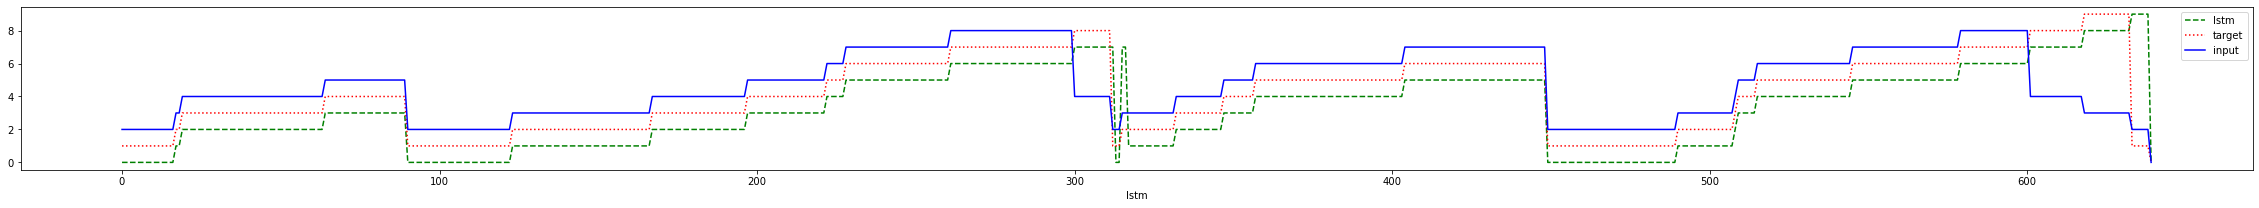

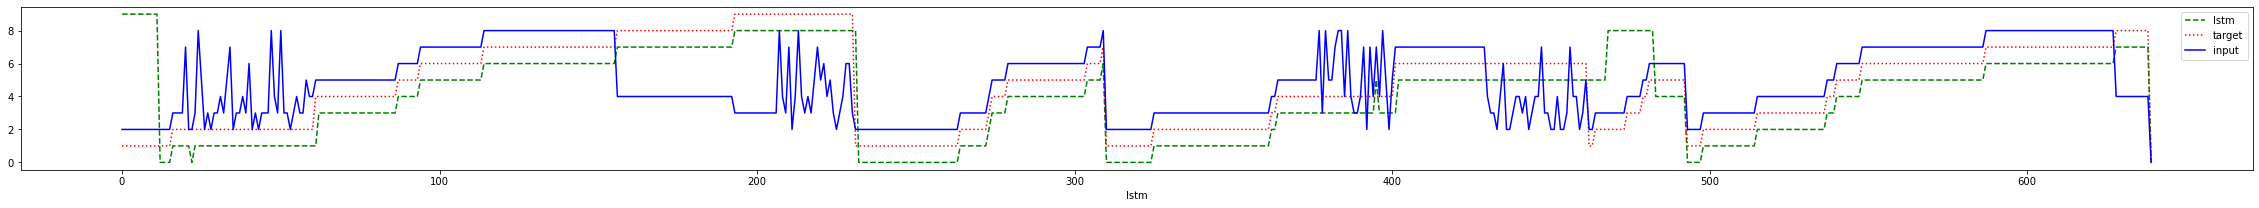

In [11]:
import matplotlib.pyplot as plt
predModel = {}
for arch in ARCHS:
    predModel[arch] = get_model(1, arch, 1)
    predModel[arch].load_weights(arch+'_model.h5')

for k in range(2):
    j = random.randint(0, inputs.shape[0]-2)
    plot_inputs = np.empty(inputs.shape[1])
    plot_preds = {}
    for arch in ARCHS:
        plot_preds[arch] = np.empty(inputs.shape[1])
        
    plot_preds["pred"] = np.empty(inputs.shape[1])
    plot_targets = np.empty(inputs.shape[1])
    
    for arch in ARCHS:
        for i in range(inputs.shape[1]-1):
#         for i in range(10):
            plot_inputs[i] = np.argmax(inputs[j:j+1, i:i+1], axis=2)[0][0]+2
            predictions = predModel[arch].predict(inputs[j:j+1, i:i+1], verbose=0)
            plot_preds["pred"][i] = np.argmax(predictions, axis=2)[0][0]
            plot_targets[i] = np.argmax(targets[j:j+1, i:i+1], axis=2)[0][0]+1
        plt.plot(plot_preds["pred"], color='g', linestyle='--', label=arch)
        plt.plot(plot_targets, color='r', linestyle='dotted', label="target")
        plt.plot(plot_inputs, color='b', label="input")
        plt.rcParams["figure.figsize"] = (40,3)
        plt.legend()
        plt.xlabel(arch)
        plt.show()